In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import statistics
import scipy.integrate as integrate
import math

In [8]:
def hash_func(s,n,A):
    out = 0
    for i in range(len(s)):
        if s[i].isdigit():
            out += A[i]*int(s[i])
        else:
            out += A[i]*(ord(s[i])-87)
    
    out = out%n
    out = '{0:031b}'.format(out)
    out = out[-31:]
    return out

In [3]:
def countZeros(num):
    count = 0
    for bit in num:
        count+=1
        if int(bit) != 0:
            return count
    return len(num)

In [4]:
def func(u, m):
    return (math.log2((2+u)/(1+u)))**m

In [5]:
def alpha_m(m):
    
    integral = integrate.quad(func, 0, np.infty, args = (m))[0]
    
    return (integral*m)**(-1)

In [6]:
def getBuckets(M, buckets, value, n, A):
    
    binary_num = hash_func(value, n, A)

    m = 2**M
    
    num_zeros = countZeros(binary_num[M:])
    if buckets[int(binary_num[:M], 2)] < num_zeros:
        buckets[int(binary_num[:M], 2)] = num_zeros
    
    return buckets

In [7]:
def hyperLogLog(buckets, M):
    
    m = 2**M
    Z = 0
    for bucket in buckets:
        Z += 2**(-bucket)
    Z = Z**(-1)

    card = (m**2)*Z*alpha_m(m)
    
    return card

In [13]:
file = open("hash.txt", "r")

In [9]:
len_strings = 33
n = (2**31)-1
A = random.sample(range(0, n-1), len_strings + 1)

In [623]:
little = ''
for i in range(0, 139000000):
    little += file.readline()
little = little.split()

In [10]:
M = 13
buckets = np.zeros(2**M)
i = 0
for line in file:
    buckets = getBuckets(M, buckets, line, n, A)
    i+=1
    if i%1000000 == 0:
        print(i, end =" | ")
print(buckets)

1000000 | 2000000 | 3000000 | 4000000 | 5000000 | 6000000 | 7000000 | 8000000 | 9000000 | 10000000 | 11000000 | 12000000 | 13000000 | 14000000 | 15000000 | 16000000 | 17000000 | 18000000 | 19000000 | 20000000 | 21000000 | 22000000 | 23000000 | 24000000 | 25000000 | 26000000 | 27000000 | 28000000 | 29000000 | 30000000 | 31000000 | 32000000 | 33000000 | 34000000 | 35000000 | 36000000 | 37000000 | 38000000 | 39000000 | 40000000 | 41000000 | 42000000 | 43000000 | 44000000 | 45000000 | 46000000 | 47000000 | 48000000 | 49000000 | 50000000 | 51000000 | 52000000 | 53000000 | 54000000 | 55000000 | 56000000 | 57000000 | 58000000 | 59000000 | 60000000 | 61000000 | 62000000 | 63000000 | 64000000 | 65000000 | 66000000 | 67000000 | 68000000 | 69000000 | 70000000 | 71000000 | 72000000 | 73000000 | 74000000 | 75000000 | 76000000 | 77000000 | 78000000 | 79000000 | 80000000 | 81000000 | 82000000 | 83000000 | 84000000 | 85000000 | 86000000 | 87000000 | 88000000 | 89000000 | 90000000 | 91000000 | 92000000

In [11]:
hyperLogLog(buckets, M)

127147271.53884749

In [12]:
127147271.53884749/125000000

1.01717817231078

In [14]:
n = 1009
len_string = 33
A = random.sample(range(0, n-1), len_string)
i = 0
y = []
for line in file:
    val = hash_func(line, n, A)
    i += 1
    y.append(int(val, 2))
    if i == 1000000:
        break

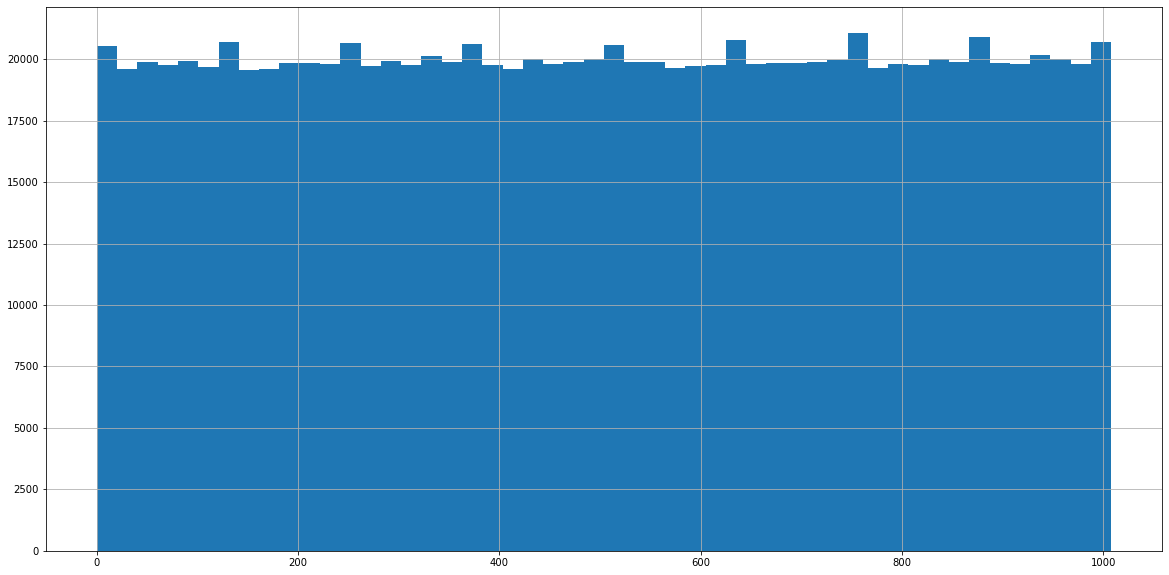

In [16]:
plt.figure(figsize=(20, 10))
plt.hist(y, bins = 50)
plt.grid()
plt.show()

In [137]:
def f_p(y): #returns the least significant 1-bit of y
    if int(y, 2) == 0:
        return 26
    
    k = int(len(y)-1)
    while 1:
        if int(y[k]) != 0:
            return int(len(y)-1) - k
        k -= 1   #the min k such that bit(y,k) ≠ 0

In [138]:
bitmax = np.zeros(27)
for v in hash_dict.values():
    for el in v:
        x = f_p(el)
        bitmax[x] = 1
print(bitmax)
idx = 0
while bitmax[idx]!=0:
    idx+=1
print(idx)
#estimated cardinality
est_card = pow(2,idx)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
15


In [139]:
est_card

32768